# Optimization of Topic Models with Grid Search Method


This Python notebook is from the Optimization of Topic Models with Grid Search Method Coursera course. I have simply edited it to add my own comments to explain parts that weren't clear to me. All credit goes to Barsha Saha. 

In this specific Python notebook, I am using a different dataset and doing my own unique analysis. 

*   **Prerequisites:** It is expected from the learners to have an idea of Topic Modelling as an unsupervised machine learning tool for efficient text mining.
*   You can refer to my other course: Introduction to Topic Modeling for Business 
  (https://www.coursera.org/projects/introduction-to-topic-modeling-for-business) for basics of topic modelling
*   The **focus** of this project is on optimizing topic models using Grid Search method available in Scikit Learn package. 
*   The code for building basic topic model is given
*   We will be working out on finding the best fit/optimized model




##Tasks to be covered
### Task 1: Upload and explore dataset
### Task 2: Clean dataset & Visualize frequent words
### Task 3: Tokenization, Lemmatization and Word Document Matrix
### Task 4: Build LDA Model with Scikit Learn
### Task 5: Grid Search for Model Optimization
### Task 6: Visualization of Top N-words of Best Model

## Import Modules

In [2]:
# Import modules

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

#TextHero
!pip install texthero -U   
import texthero as hero

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
!pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 245kB 4.0MB/s 
     |████████████████████████████████| 1.4MB 8.1MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=ad5fa9aa720b652eef84d581a268d6f3b5560266ce267120a22a718e69c269ee
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.6MB 2.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=f6bc2c6b034965184a44091881db54374d8b86c18f6920af366c759aea31bde1
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


## Task 1: Upload and explore dataset

In [5]:
# Upload .csv file
from google.colab import files
uploaded = files.upload()

Saving BookDataset.csv to BookDataset.csv


In [6]:
# Store dataset in a Pandas Dataframe
import io
df = pd.read_csv(io.BytesIO(uploaded['BookDataset.csv']))

In [7]:
# Dimesnion
print(df.shape)

(56009, 25)


In [8]:
# Dataset
df.head()

,authors,bestsellers-rank,categories,description,dimension-x,dimension-y,dimension-z,edition,edition-statement,for-ages,format,id,illustrations-note,imprint,index-date,isbn10,isbn13,lang,publication-date,publication-place,rating-avg,rating-count,title,url,weight
0,[1],NaN,"[334, 335, 341, 2622, 352, 2626, 353, 2627]",Renowned urban artist Shepard Fairey's new loo...,111.0,181.0,20.0,NaN,Repr.,NaN,1,9780141036144,NaN,NaN,2020-05-31 12:59:51,141036141,9.780141e+12,en,2008-10-01,1.0,4.18,2918204.0,1984,/1984-George-Orwell/9780141036144,184.00
1,[2],67532,"[376, 378, 868, 873, 900, 2771, 3097, 2590]","These 100 skills, adapted for civilians from a...",140.0,210.0,18.0,NaN,NaN,NaN,1,9781501143908,b&w illustrations t-o; rounded edges,NaN,2020-05-31 13:00:12,1501143905,9.781501e+12,en,2016-11-16,2.0,4.01,425.0,100 Deadly Skills: Survival Edition : The SEAL...,/100-Deadly-Skills-Survival-Edition-Clint-Emer...,367.00
2,"[3, 4]",150327,"[2978, 2980]",The world is full of pointless things. From ra...,193.0,197.0,21.0,NaN,NaN,NaN,1,9781444762051,integrated black and white,Coronet Books,2020-05-31 13:00:34,1444762052,9.781445e+12,en,2013-05-23,1.0,3.59,539.0,The 100 Most Pointless Things in the World : A...,/100-Most-Pointless-Things-World-Alexander-Arm...,220.00
3,[5],85902,"[2948, 2953]",Delight children and adults alike by creating ...,148.0,210.0,12.7,NaN,NaN,NaN,1,9781784943462,"20 illustrations, 160 photographs in full colour",STERLING,2020-05-31 13:00:55,1784943460,9.781785e+12,en,2017-11-14,2.0,3.66,9.0,50 Knitted Dolls,/50-Knitted-Dolls-Sarah-Keen/9781784943462,771.11
4,[6],54186,"[2942, 2948, 2953]",Make your own collection of irresistibly cute ...,155.0,215.0,4.0,NaN,NaN,NaN,1,9781782216957,"100 Illustrations, color",NaN,2020-05-31 13:01:36,1782216952,9.781782e+12,en,2019-06-04,3.0,4.66,6.0,20 to Knit: Pocket Pets,/20-Knit-Pocket-Pets-Sachiyo-Ishii/9781782216957,130.00


## Task 2: Clean dataset & Visualize frequent words

In [9]:
#Pass a custom pipeline as argument to clean

from texthero import preprocessing
# https://pypi.org/project/texthero/
# Texthero is a really good library built off of Pandas and it allows for those with minimal knowledge of the NLP space to utilize powerful tools. 

custom_pipeline = [preprocessing.lowercase, # much easier than previous solution which was to df.remove. 
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls]
data = hero.clean(df['description'])

In [10]:
# Custom STOPWORDS removal
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["notebook", "calendar", "page", "journal", "organizer", "book", "planner", "agenda", 
                 "diary", "datebook", "cover", "year", "blank", "dictionary", "edition", "books",
                  "daily", "handwriting", "planners", "calendars", "organizers", "grade", "practice", 
                 "pages", "weekly", "monthly", "appointment", "grades", "primary", "guide", "datebooks",
                  "day","agendas","volume", "de"])) ## Add as per requirement
data = hero.remove_stopwords(data, custom_stopwords)

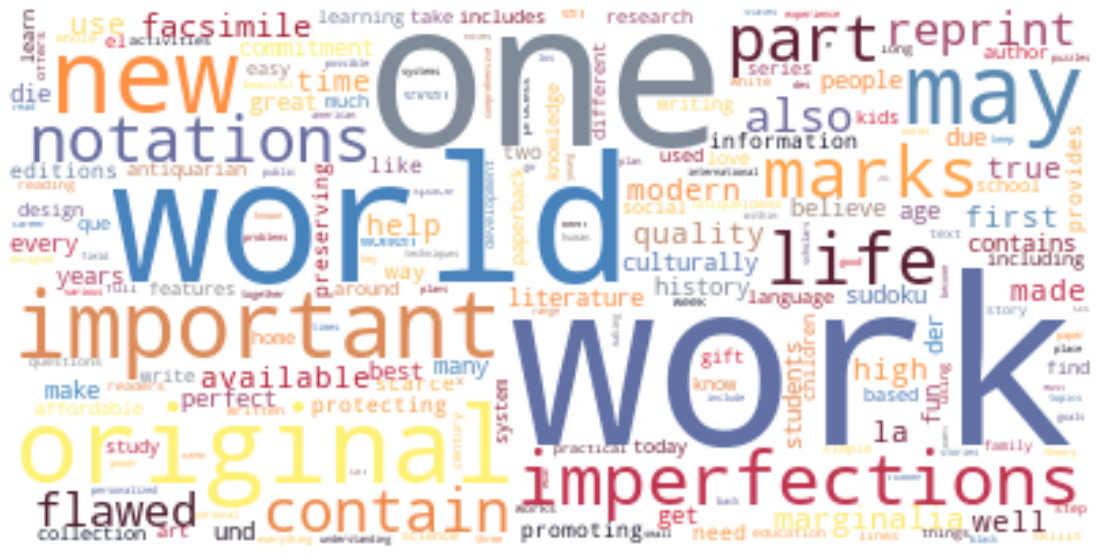

In [13]:
hero.visualization.wordcloud(data, font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

## Task 3: Tokenization, Lemmatization and Word Document Matrix

In [14]:
# Tokenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['renowned', 'urban', 'artist', 'shepard', 'fairey', 'new', 'look', 'orwell', 'dystopian', 'masterpiece']]


In [15]:
# Lemmatize
# Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, 
# normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
# tl;dr put the verbs in their "stem" form. 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['renowned urban artist', 'skill adapt civilian actual field experience special force operation offer complete hand practical help survive wild matter climate terrain prepare crisis critical life save knowledge stay safe hostile environment disaster']


In [16]:
# Word-Document Matrix
# This converts a collection of text documents to a matrix of token counts. 
# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
# In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. 

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            

data_vectorized = vectorizer.fit_transform(data_lemmatized)

## Task 4: Build LDA Model with Scikit Learn

In [17]:
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=15, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [18]:
#Evaluate model quality

# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))


Log Likelihood:  -12006549.618007382
Perplexity:  1638.6188197039658


In [19]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      114.344879  114.308296       1        1  12.199882
10     105.821045  -93.749626       2        1  11.369696
5     -138.334473   95.320763       3        1  11.343621
14      -7.436697  111.259697       4        1  11.322834
3     -207.550629 -105.472603       5        1   8.093752
8       52.817650   14.603765       6        1   7.313786
4      168.010849    6.806950       7        1   5.916067
1      -94.169601 -157.789551       8        1   5.825720
7     -122.849174  -39.059418       9        1   4.959726
2      -94.894264  195.408295      10        1   4.579618
13      24.927401 -180.464874      11        1   4.365087
12     -53.413467   26.832108      12        1   3.808856
0      -12.255850  -72.093201      13        1   3.500380
11    -224.217957   28.070581      14        1   2.896905
9       36.154255  209.427582      15        1   2.504070, topic_info=              Term          Freq         Total Category  logprob  loglift
8773          work  18630.000000  18630.000000  Default  30.0000  30.0000
5449      original   9616.000000   9616.000000  Default  29.0000  29.0000
1659       contain  11503.000000  11503.000000  Default  28.0000  28.0000
3959  imperfection   7240.000000   7240.000000  Default  27.0000  27.0000
3972     important   8458.000000   8458.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
5391          open    375.716460    878.627747  Topic15  -4.6832   2.8377
995          build    435.832229   1770.117916  Topic15  -4.5348   2.2857
4726          make    576.562261  12503.546019  Topic15  -4.2549   0.6106
3546         great    448.996690   4017.805265  Topic15  -4.5050   1.4958
441           area    308.076844   1777.687346  Topic15  -4.8817   1.9345

[826 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
66        2  0.023070   account
66        4  0.887243   account
66        9  0.089397   account
99       10  0.997992    active
104       1  0.357463  activity
...     ...       ...       ...
8819      8  0.997704    yearly
8827      1  0.873727     young
8827      2  0.050333     young
8827      9  0.043235     young
8827     10  0.032265     young

[1415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 11, 6, 15, 4, 9, 5, 2, 8, 3, 14, 13, 1, 12, 10])

## Task 5: Grid Search for Model Optimization

In [20]:
# Grid Search for Best LDA Model
# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# This is computationally expensive and usually takes time... 

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Model
lda = LatentDirichletAllocation()

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [21]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -2475506.647060643
Model Perplexity:  1279.5872262414694


## Task 6: Visualization of Top N-words of Best Model

In [22]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  17.304892
4       0.648955  71.707100       2        1  17.098474
8      71.019684   9.971006       3        1  12.993973
9       3.785981  33.185135       4        1  12.367090
7     -42.666500  -9.222070       5        1  10.788604
6      -3.621689 -43.526516       6        1  10.309635
3      -3.632402  -4.171708       7        1   8.311135
0     -36.584400  35.804413       8        1   3.966509
2      44.391380  50.615383       9        1   3.523295
5      40.235809 -31.591665      10        1   3.336394, topic_info=              Term          Freq         Total Category  logprob  loglift
1659       contain  10699.000000  10699.000000  Default  30.0000  30.0000
5449      original   9405.000000   9405.000000  Default  29.0000  29.0000
8773          work  18343.000000  18343.000000  Default  28.0000  28.0000
3959  imperfection   7132.000000   7132.000000  Default  27.0000  27.0000
4778          mark   7025.000000   7025.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
7970         thing    293.324475   2214.073255  Topic10  -5.2177   1.3790
4656          lose    263.363182    976.286421  Topic10  -5.3255   2.0901
8659           way    301.641342   4283.689337  Topic10  -5.1897   0.7469
3708          help    296.952266   5820.090469  Topic10  -5.2054   0.4248
3064       feature    265.865192   3379.633022  Topic10  -5.3160   0.8577

[796 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
79        2  0.014955       ace
79        8  0.972076       ace
104       1  0.050134  activity
104       2  0.383419  activity
104       3  0.010592  activity
...     ...       ...       ...
8827      3  0.008682     young
8827      4  0.004341     young
8827      6  0.253649     young
8827      7  0.004341     young
8827      9  0.001240     young

[2303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 9, 10, 8, 7, 4, 1, 3, 6])

In [23]:
# Reflections:
# This exercise shows how you can analyze a massive corpus of text and split data into "topics" which contain certain words that appear 
# frequently amongst those topics. In this case, we have 10 topics and 10 words that reflect those topics. What this data can tell us is 
# how important and how frequent certain words are in the corpus - what themes/etc. may emerge. 

# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,question,test,exam,include,answer,step,minor,note,write,gift
Topic 1,life,time,story,make,know,live,people,world,love,good
Topic 2,object,dog,include,small,planet,note,discover,space,orbit,solar
Topic 3,perfect,use,write,gift,color,make,language,goal,design,paper
Topic 4,student,use,help,learn,provide,skill,include,need,teacher,make
Topic 5,contain,paperback,week,plan,black,white,home,funny,theme,make
Topic 6,include,puzzle,game,work,collection,art,new,play,design,artist
Topic 7,work,original,imperfection,mark,notation,contain,reprint,flaw,facsimile,marginalia
Topic 8,die,history,social,study,work,political,new,world,change,law
Topic 9,line,use,kid,fun,personalize,application,present,include,provide,field
